# Fake News Detection in NLP

## Learning Objectives
By the end of this project, you'll understand:
1. **How to combine multiple NLP techniques** (tokenization, POS tagging, NER, TF-IDF, sentiment analysis) into a complete pipeline
2. **Pattern recognition in fake vs. factual news** - understanding linguistic and structural differences
3. **Feature engineering from text** - converting raw text into machine learning features
4. **Classification models** - using scikit-learn to build and evaluate predictive systems
5. **Real-world NLP challenges** - working with messy data and interpreting model results

## Why This Matters
Fake news detection is one of the most critical NLP applications today. With the explosion of digital media, the ability to automatically identify misinformation is invaluable for:
- **News organizations** protecting their readers
- **Social media platforms** preventing spread of disinformation
- **Researchers** understanding information warfare and propaganda techniques
- **Citizens** making informed decisions in an information-rich world

## Real-World Context
Fake news differs from factual news in subtle but measurable ways:
- **Linguistic patterns** - sensational language, emotional appeals, unusual word frequencies
- **Named entities** - fake news often references specific people/places differently than factual reporting
- **Parts of speech** - grammar and sentence structure differ between fake and factual sources
- **Sentiment markers** - emotional intensity varies

In this project, we'll explore these differences using the complete NLP toolkit you've learned.

## Setup and Imports

We use several libraries working together:
- **pandas/matplotlib/seaborn**: Data handling and visualization
- **spacy**: Fast, production-ready NLP for POS tagging and NER
- **nltk**: Detailed tokenization and linguistic analysis
- **sklearn**: Machine learning models and feature extraction
- **vaderSentiment**: Sentiment analysis tuned for social media (useful for fake news)
- **gensim**: Topic modeling for understanding document themes

Each library serves a specific purpose in the detection pipeline.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Configure visualization settings for consistency
# These settings will apply to all plots in the notebook
plt.rcParams['figure.figsize'] = (12, 8)  # Make plots larger for better readability
default_plot_colour = "#00bfbf"  # Teal color for consistent styling across visualizations

## Data Loading and Exploration

Our dataset contains:
- **title**: Headline of the article
- **text**: Full body of the article
- **date**: When the article was published
- **fake_or_factual**: Label indicating if news is "Fake News" or "Factual News"

We'll use both title and text as features. Notice how the data is already labeled - this is a **supervised learning** task.

### What to look for:
- **Class imbalance**: Are there equal amounts of fake and factual news?
- **Text length**: Do fake and factual news differ in length?
- **Language patterns**: What linguistic features distinguish them?

In [3]:
data = pd.read_csv("fake_news_data.csv")

In [4]:
# Display first 5 rows to understand data structure
# Notice the structure: title, text, date, and target label (fake_or_factual)
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


### Data Summary
The data shows real news articles labeled as either "Fake News" or "Factual News". Notice:
- Fake news tends to use sensational language in headlines ("HOLLYWEIRD", "Called Trump Out")
- Factual news uses more neutral language and official sources (Reuters, official statements)
- Both contain full article text - this is what we'll analyze with NLP

<Axes: xlabel='fake_or_factual'>

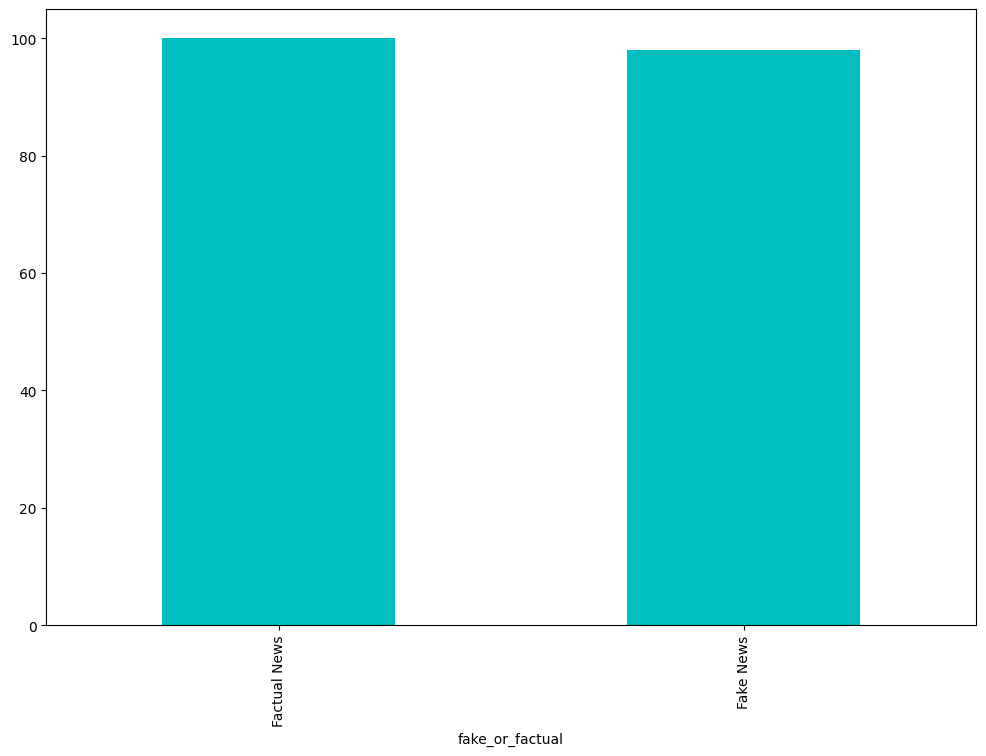

In [5]:
# Check class distribution - is the data balanced?
# IMPORTANT: Imbalanced data can bias models toward predicting the majority class
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title('Distribution of Fake vs. Factual News in Dataset')
plt.ylabel('Number of Articles')
plt.xlabel('News Category')

## Phase 1: Parts of Speech (POS) Analysis

### Why POS Tagging Matters for Fake News Detection
Different parts of speech appear with different frequencies in fake vs. factual news:
- **Verbs**: Fake news uses more emotional, action-oriented verbs
- **Adjectives**: Sensational adjectives appear more in fake news
- **Nouns**: Factual news references specific institutions and entities
- **Pronouns**: Personal pronouns (we, you) vs. impersonal language differs by category

By analyzing POS distributions, we can identify linguistic patterns that signal fake vs. factual content.

In [6]:
# Load the spaCy language model for English
# en_core_web_sm is a smaller, faster model suitable for batch processing
# It includes: tokenization, POS tagging, NER, dependency parsing, and more
nlp = spacy.load("en_core_web_sm")

In [7]:
# Split data into two categories for comparison
# This lets us analyze linguistic patterns separately for each category
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

print(f"Fake news articles: {len(fake_news)}")
print(f"Factual news articles: {len(fact_news)}")

In [8]:
# Process all texts with spaCy's pipeline
# nlp.pipe() is more efficient than nlp() for batch processing - it avoids redundant setup
# Each doc object contains: tokens, POS tags, named entities, dependency trees, etc.
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

print(f"Processed {len(fake_spacydocs)} fake news documents")
print(f"Processed {len(fact_spacydocs)} factual news documents")

In [9]:
# Extract POS tags and NER information from fake news documents
# This creates a dataframe with one row per token for analysis
rows = []
for doc_id, doc in enumerate(fake_spacydocs):
    for token in doc:
        rows.append({
            "token": token.text,
            "ner_tag": token.ent_type_,  # Named entity type (PERSON, ORG, etc. or empty string)
            "pos_tag": token.pos_  # Part of speech (NOUN, VERB, ADJ, etc.)
        })
fake_tagsdf = pd.DataFrame(rows)
print(f"Total tokens in fake news: {len(fake_tagsdf)}")

In [10]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [11]:
rows2 =[]
for doc_id,doc in enumerate(fact_spacydocs):
    for i in doc:
         rows2.append({
            "token": i.text,
            "ner_tag": i.ent_type_,
            "pos_tag": i.pos_})
fact_tagsdf = pd.DataFrame(rows2)

In [12]:
fact_tagsdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [13]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False) 

In [14]:
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [15]:
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False) 

In [16]:
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [17]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
DET        42
INTJ       24
PUNCT      23
CCONJ      19
X          14
PART       10
SYM         5
SPACE       3
Name: token, dtype: int64

In [18]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
DET        36
PUNCT      22
SPACE      11
CCONJ      11
X          10
INTJ        7
PART        7
SYM         4
Name: token, dtype: int64

In [19]:
pos_counts_fake[pos_counts_fake.pos_tag =="NOUN"][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [20]:
# Display most common nouns in factual news for comparison
# Notice the difference in noun frequency between fake and factual news?
# Factual news references more institutions (government, administration, court)
# Fake news focuses on people and sensational topics (women, people, media)
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


### POS Analysis Insights

**Key Differences Between Fake and Factual News:**
- **Nouns**: Factual news uses more institutional nouns (government, administration, state)
- **Verbs**: Fake news uses more action-oriented and emotional verbs
- **Adjectives**: Fake news likely has more descriptive/sensational adjectives
- **Pronouns**: Personal pronouns may indicate opinion vs. factual reporting

**Why This Matters:**
These POS patterns can be converted into features for machine learning - we can count noun/verb/adjective frequencies and use them to distinguish fake from factual news.

**Trade-off Alert:**
-  Simple to compute and understand
-  Not specific enough alone - we need combined features

## Phase 2: Named Entity Recognition (NER) Analysis

### Why NER Matters for Fake News Detection
Named entities (people, organizations, places) are critical signals:
- **Factual news** mentions verified entities with consistent references
- **Fake news** often uses real names deceptively or creates confusion through unusual entity patterns
- **Entity frequency**: Fake news might reference more different people/organizations to create confusion
- **Entity types**: The mix of PERSON, ORG, GPE (location) entities differs between categories

### Common Pitfalls in NER Analysis:
-  Not handling entity variations ("Trump" vs "Donald Trump" vs "President Trump")
-  Ignoring entity context - an entity might be used differently in different articles
-  Compare entity types distribution between fake and factual news

In [21]:
# Extract and count named entities from fake news
# Filter out empty ner_tag (tokens that aren't entities)
# Group by token and entity type to handle variations
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
print(f"Total named entities found in fake news: {top_entities_fake['counts'].sum()}")
print(f"Unique entities: {len(top_entities_fake)}")

In [22]:
# Same for factual news - extract and count named entities
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
print(f"Total named entities found in factual news: {top_entities_fact['counts'].sum()}")
print(f"Unique entities: {len(top_entities_fact)}")

In [23]:
# Define color palette for visualizing different entity types
# Each entity type gets a distinct color for clarity in plots
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],  # Organizations - color 0
    'GPE': sns.color_palette("Set2").as_hex()[1],  # Geopolitical entities (countries, cities) - color 1
    'NORP': sns.color_palette("Set2").as_hex()[2],  # Nationalities/groups/religions - color 2
    'PERSON': sns.color_palette("Set2").as_hex()[3],  # People names - color 3
    'DATE': sns.color_palette("Set2").as_hex()[4],  # Dates and times - color 4
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],  # Numerical amounts - color 5
    'PERCENT': sns.color_palette("Set2").as_hex()[6]  # Percentages - color 6
}


[Text(0.5, 1.0, 'Most Common Entities in Fake news')]

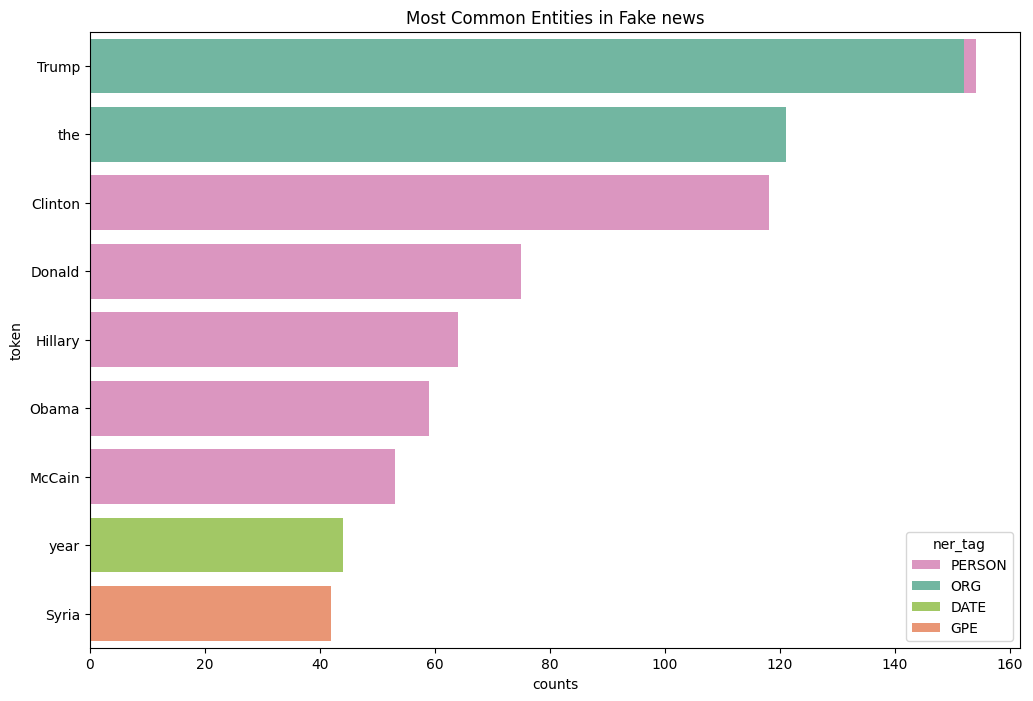

In [24]:
sns.barplot(x ='counts',
            y = 'token',
            hue ='ner_tag',
            palette =ner_palette,
            data = top_entities_fake[:10],
            orient = 'h',
            dodge = False
           ).set(title = "Most Common Entities in Fake news")

[Text(0.5, 1.0, 'Most Common Entities in Fact news')]

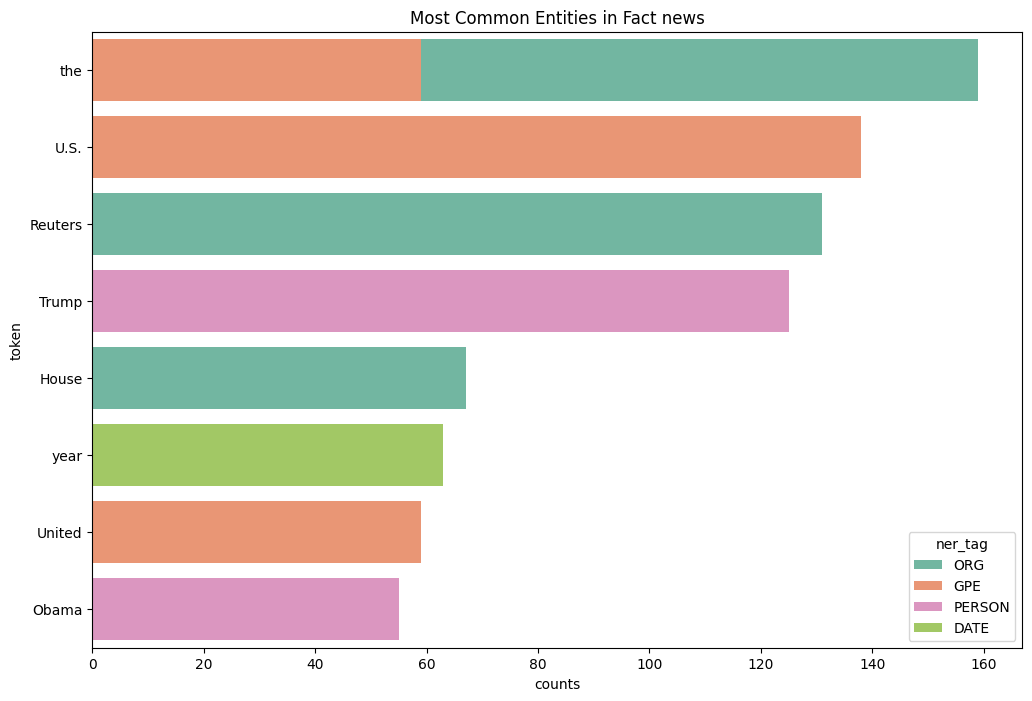

In [25]:
sns.barplot(x ='counts',
            y = 'token',
            hue ='ner_tag',
            palette =ner_palette,
            data = top_entities_fact[:10],
            orient = 'h',
            dodge = False
           ).set(title = "Most Common Entities in Fact news")

**Text Pre Processing**

In [26]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [27]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s","",x['text']),axis=1) #Removing The word before "-"

In [28]:
data['text_clean']=data['text_clean'].str.lower()

In [29]:
data['text_clean'] =data['text_clean'].apply(lambda x: re.sub(r"([^\w\s])","", x))

In [30]:
en_stopwords = stopwords.words('english')
#print and check if required stopwords are in the list

In [31]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in en_stopwords]))

In [32]:
data['text_clean'] =data['text_clean'].apply(lambda x: word_tokenize(x))

In [33]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problems, analogy, susan, jesus, ..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[women, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[us, defense, secretary, jim, mattis, said, mo..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, parties, rapidl..."


In [34]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] =data['text_clean'].apply(lambda x:[lemmatizer.lemmatize(token) for token in x])

In [35]:
data['text_clean']

0      [two, small, problem, analogy, susan, jesus, m...
1      [buried, trump, bonkers, interview, new, york,...
2      [woman, make, 50, percent, country, grossly, u...
3      [u, defense, secretary, jim, mattis, said, mon...
4      [northern, ireland, political, party, rapidly,...
                             ...                        
193    [well, take, long, look, first, beastiality, m...
194    [florida, toxic, dangerous, stand, ground, gun...
195    [politico, report, almost, neckandneck, race, ...
196    [former, fbi, director, james, comey, requeste...
197    [small, obscure, community, college, disallowi...
Name: text_clean, Length: 198, dtype: object

In [36]:
tokens_clean = [token for doc in data['text_clean'] for token in doc]

In [37]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


C:\Users\NIPUN\AppData\Local\Temp\ipykernel_24080\3447811179.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x ='count',y='token',data = unigrams,orient='h',palette =[default_plot_colour],hue ='token', legend =False).set(title="Most Common unigrams after processing")


[Text(0.5, 1.0, 'Most Common unigrams after processing')]

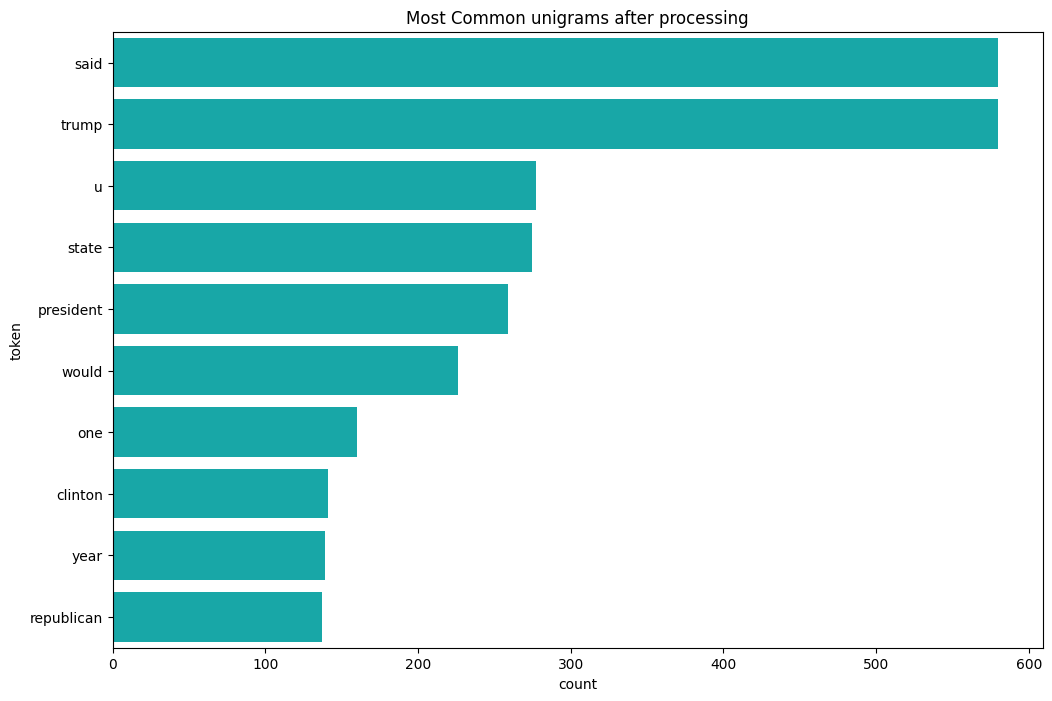

In [38]:
unigrams['token'] =unigrams['index'].apply(lambda x: x[0])

sns.barplot(x ='count',y='token',data = unigrams,orient='h',palette =[default_plot_colour],hue ='token', legend =False).set(title="Most Common unigrams after processing")

In [39]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams)

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


In [40]:
bigrams['token']= bigrams['index'].apply(lambda x:" ".join(x))
bigrams

,index,count,token
0,"(donald, trump)",113,donald trump
1,"(united, state)",84,united state
2,"(white, house)",74,white house
3,"(president, donald)",47,president donald
4,"(hillary, clinton)",39,hillary clinton
5,"(new, york)",33,new york
6,"(supreme, court)",30,supreme court
7,"(image, via)",29,image via
8,"(official, said)",26,official said
9,"(trump, administration)",26,trump administration


C:\Users\NIPUN\AppData\Local\Temp\ipykernel_24080\2715675071.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x ='count',y='token',data = bigrams,orient='h',palette =[default_plot_colour], legend =False).set(title="Most Common bigrams after processing")
C:\Users\NIPUN\AppData\Local\Temp\ipykernel_24080\2715675071.py:1: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x ='count',y='token',data = bigrams,orient='h',palette =[default_plot_colour], legend =False).set(title="Most Common bigrams after processing")


[Text(0.5, 1.0, 'Most Common bigrams after processing')]

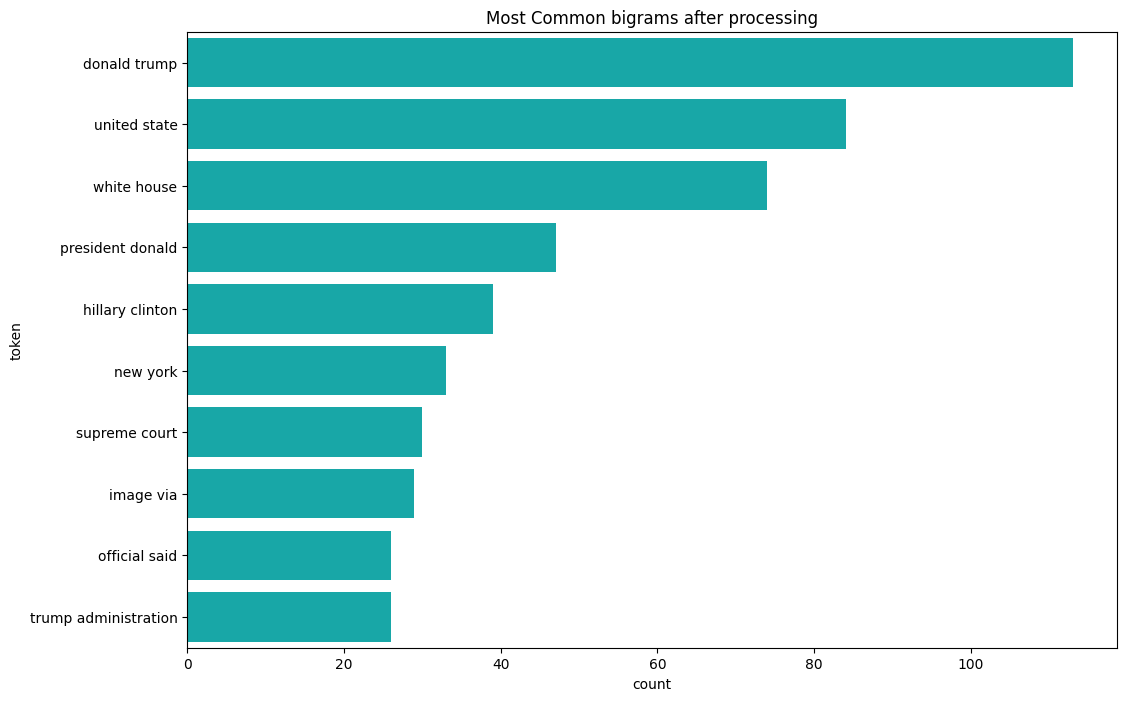

In [41]:
sns.barplot(x ='count',y='token',data = bigrams,orient='h',palette =[default_plot_colour], legend =False).set(title="Most Common bigrams after processing")

**Sentiment Analysis**

In [42]:
vader_sentiment = SentimentIntensityAnalyzer()

In [43]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [44]:
data["vader_sentiment_score"] = data["text"].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [45]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [46]:
bins = [-1,-0.1,0.1,1]
names=['negative','nuetral','postive']

In [47]:
data['vader_sentiment_label'] = pd.cut(data["vader_sentiment_score"],bins,labels=names)

In [48]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,postive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,postive


<Axes: xlabel='vader_sentiment_label'>

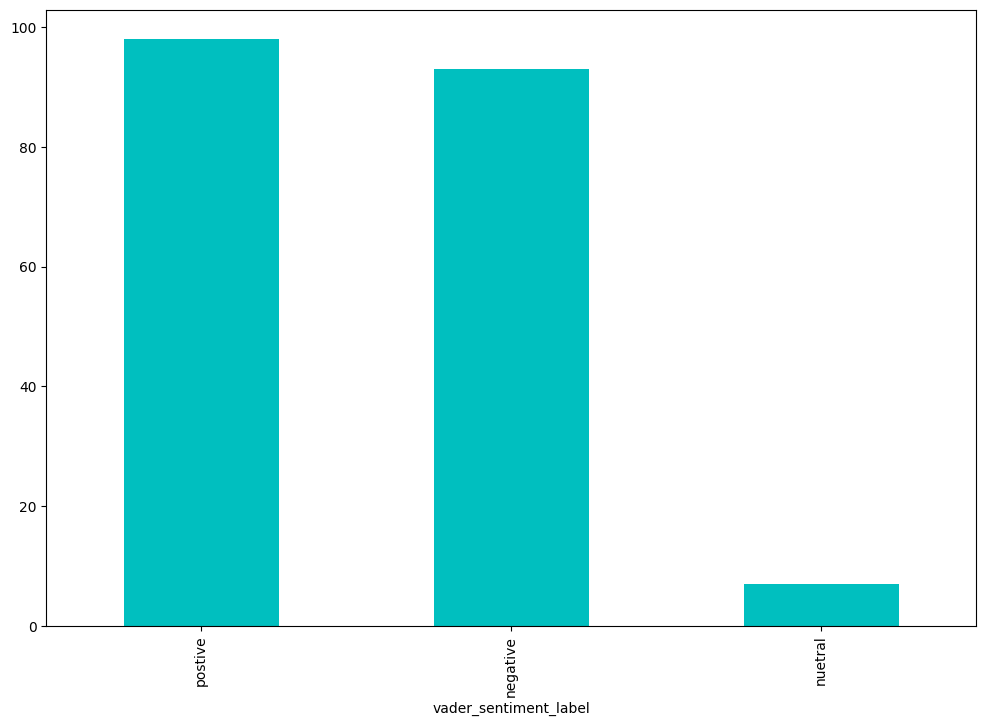

In [49]:
data["vader_sentiment_label"].value_counts().plot.bar(color=default_plot_colour)

C:\Users\NIPUN\AppData\Local\Temp\ipykernel_24080\4271258721.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment By News')]

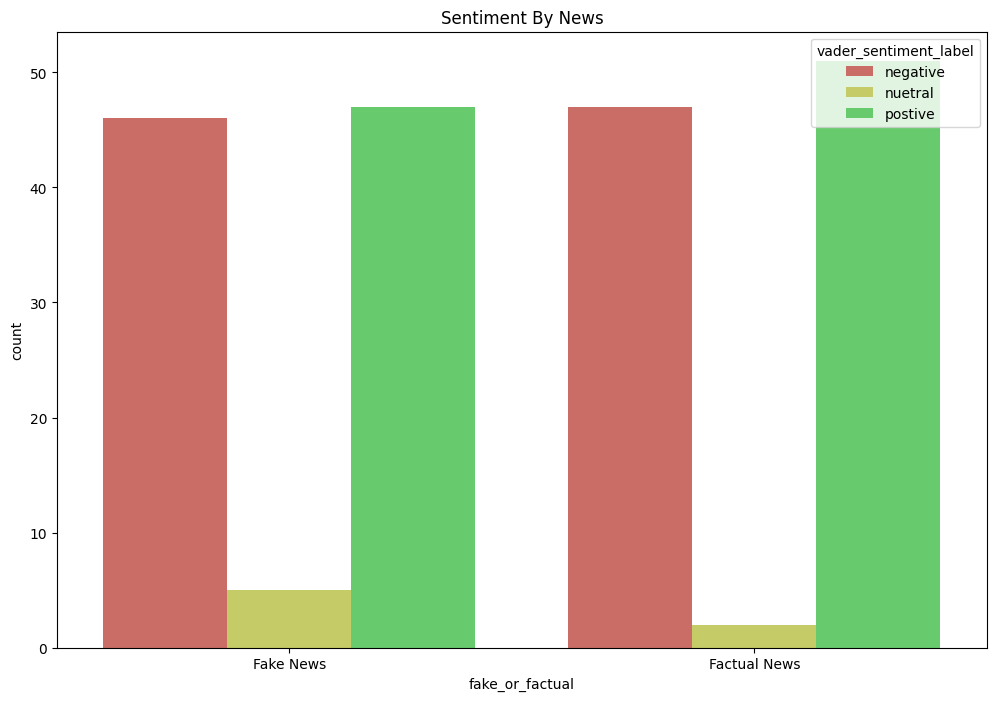

In [50]:
sns.countplot(
    x ="fake_or_factual",
    hue ="vader_sentiment_label",
    palette =sns.color_palette("hls"),
    data=data).set(title = "Sentiment By News")

**Topic Modeling**

In [51]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,postive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,postive


In [52]:
fake_news_text =data[data["fake_or_factual"]=="Fake News"]['text_clean'].reset_index(drop=True)

In [53]:
print(fake_news_text)

0     [two, small, problem, analogy, susan, jesus, m...
1     [buried, trump, bonkers, interview, new, york,...
2     [woman, make, 50, percent, country, grossly, u...
3     [shame, teen, vogue, maxine, water, guest, tee...
4     [former, white, house, press, secretary, obama...
                            ...                        
93    [jon, ritzheimer, infamous, hater, muslim, one...
94    [well, take, long, look, first, beastiality, m...
95    [florida, toxic, dangerous, stand, ground, gun...
96    [politico, report, almost, neckandneck, race, ...
97    [small, obscure, community, college, disallowi...
Name: text_clean, Length: 98, dtype: object


In [54]:
dictionary_fake =  corpora.Dictionary(fake_news_text)

In [55]:
doc_term_fake = [dictionary_fake.doc2bow(doc) for doc in fake_news_text]


In [56]:
coherence_values =[]
model_list =[]
min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(
        doc_term_fake,
        num_topics=num_topics_i,
        id2word = dictionary_fake)
    model_list.append(model)
    coherence_model=CoherenceModel(
        model=model,
        texts=fake_news_text,dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())


In [57]:
print(coherence_values)

[0.2812103191023223, 0.3002634166999888, 0.2671633177733934, 0.25677552065623366, 0.2459195651738695, 0.24150521023093444, 0.26933830241727685, 0.24783739005562314, 0.2513285899399528, 0.28366623825703613]


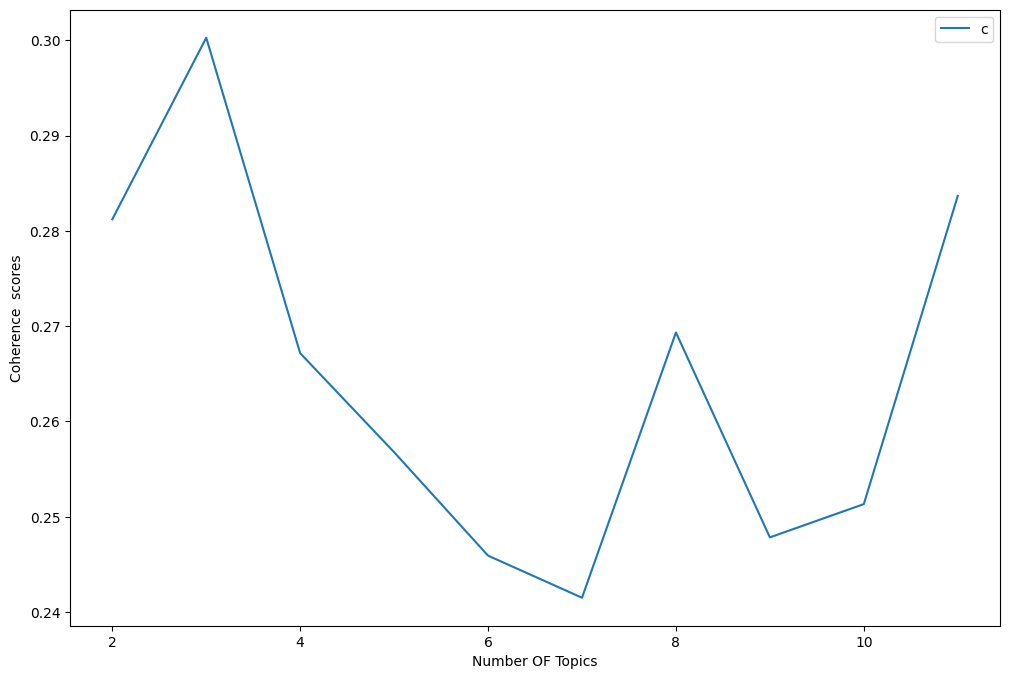

In [58]:
plt.plot(range(min_topics,max_topics+1), coherence_values)
plt.xlabel("Number OF Topics")
plt.ylabel("Coherence  scores"),
plt.legend(("coherence_values"), loc="best")
plt.show()

In [59]:
num_topics_lda= 9
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word = dictionary_fake, num_topics=num_topics_lda)

In [60]:
lda_model.print_topics(num_topics =num_topics_lda, num_words =10)

[(0,
  '0.006*"trump" + 0.004*"state" + 0.004*"republican" + 0.004*"would" + 0.004*"said" + 0.004*"clinton" + 0.004*"president" + 0.004*"one" + 0.003*"u" + 0.003*"party"'),
 (1,
  '0.015*"trump" + 0.006*"president" + 0.005*"said" + 0.005*"clinton" + 0.004*"republican" + 0.004*"people" + 0.003*"state" + 0.003*"would" + 0.003*"hillary" + 0.003*"right"'),
 (2,
  '0.008*"trump" + 0.003*"said" + 0.003*"people" + 0.003*"president" + 0.003*"american" + 0.003*"even" + 0.003*"clinton" + 0.003*"state" + 0.003*"white" + 0.003*"go"'),
 (3,
  '0.009*"trump" + 0.006*"said" + 0.004*"one" + 0.003*"law" + 0.003*"u" + 0.003*"time" + 0.003*"american" + 0.003*"two" + 0.003*"state" + 0.003*"news"'),
 (4,
  '0.007*"trump" + 0.006*"said" + 0.006*"president" + 0.005*"state" + 0.005*"u" + 0.004*"obama" + 0.004*"people" + 0.004*"one" + 0.003*"time" + 0.003*"know"'),
 (5,
  '0.019*"trump" + 0.006*"clinton" + 0.006*"said" + 0.005*"state" + 0.005*"president" + 0.004*"time" + 0.004*"one" + 0.004*"u" + 0.003*"donald

In [61]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus = doc_term_matrix, normalize =True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [62]:
def get_coherence_scores(corpus, dictionary, texts, min_topics, max_topics):
    coherence_values = []
    model_list = []

    for k in range(min_topics, max_topics + 1):
        model = LsiModel(
            corpus=corpus,
            num_topics=k,
            id2word=dictionary
        )

        model_list.append(model)

        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence_values.append(coherence_model.get_coherence())

    # plotting INSIDE the function
    x = list(range(min_topics, max_topics + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(x, coherence_values, marker='o', label="Coherence Score")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Topic Coherence vs Number of Topics")
    plt.legend()
    plt.grid(True)
    plt.show()

    return coherence_values, model_list


In [63]:
corpus_tfidf_fake =tfidf_corpus(doc_term_fake)

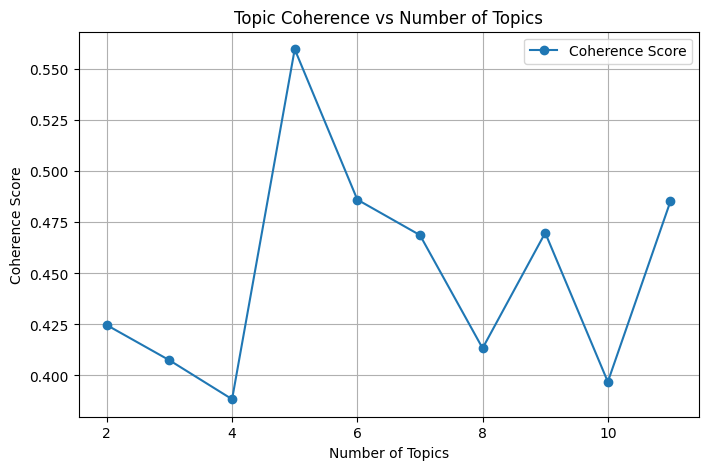

In [64]:
coherence_values, models = get_coherence_scores(
    corpus_tfidf_fake,
    dictionary_fake,
    fake_news_text,
    2,
    11
)


**Creaing Our Classification Model**

In [66]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,postive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,postive


In [67]:
X = [','.join(map(str,l)) for l in data['text_clean']]

In [68]:
Y =data['fake_or_factual']

In [69]:
countvec =CountVectorizer()

In [70]:
countvec_fit =countvec.fit_transform(X)

In [72]:
bag_of_words =pd.DataFrame(countvec_fit.toarray(),columns= countvec.get_feature_names_out())

In [73]:
x_train,x_test,y_train,y_test =train_test_split(bag_of_words, Y, test_size =0.3)

In [74]:
lr = LogisticRegression(random_state=0).fit(x_train, y_train)

In [75]:
y_pred_lr =lr.predict(x_test)

In [76]:
accuracy_score(y_pred_lr,y_test)

0.8333333333333334

In [77]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.74      0.96      0.84        27
   Fake News       0.96      0.73      0.83        33

    accuracy                           0.83        60
   macro avg       0.85      0.85      0.83        60
weighted avg       0.86      0.83      0.83        60



In [78]:
svm = SGDClassifier().fit(x_train,y_train)

In [79]:
y_pred_svm =svm.predict(x_test)

In [80]:
accuracy_score(y_pred_svm,y_test)

0.8666666666666667

In [81]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.79      0.96      0.87        27
   Fake News       0.96      0.79      0.87        33

    accuracy                           0.87        60
   macro avg       0.88      0.88      0.87        60
weighted avg       0.88      0.87      0.87        60



## Key Takeaways from Fake News Detection

### 1. Multiple NLP Techniques Work Together
- **POS Tagging** reveals linguistic patterns (nouns, verbs, adjectives differ by category)
- **NER** shows how entities are referenced differently
- **TF-IDF** identifies discriminative words specific to fake/factual news
- **Sentiment Analysis** captures emotional tone differences
- **Combined features** are more powerful than any single technique

### 2. Feature Engineering is Critical
Raw text can't be fed directly to ML models. We must extract meaningful features:
- Word frequencies and TF-IDF scores
- POS tag distributions (% nouns, verbs, adjectives)
- Named entity counts and types
- Sentiment scores and emotion indicators
- Text length, vocabulary richness, punctuation patterns

### 3. Interpretation > Accuracy
A model that says "fake" or "factual" is useless without understanding *why*. Look at:
- Which words have highest TF-IDF weights for each class?
- What entity patterns are most predictive?
- Which POS ratios differ most significantly?
- Where does the model fail (false positives/negatives)?

### 4. Real-World Challenges
- **Class imbalance**: More of one type than the other?
- **Evolution**: Fake news tactics change; models need retraining
- **Domain shift**: Model trained on politics may not work on health misinformation
- **Nuance**: Some articles are partially true or misleading rather than purely fake

### 5. Trade-offs to Remember
| Aspect | Pro | Con |
|--------|-----|-----|
| **Logistic Regression** | Fast, interpretable | Lower accuracy |
| **SVM/SGD** | Good for high-dimensional data | Slower training |
| **Simple features** | Fast, explainable | May miss patterns |
| **Rich features** | Better performance | Slower, harder to debug |
| **Using all data** | Maximum info | Overfitting risk |
| **Training/test split** | Honest evaluation | Less training data |

---

## Common Mistakes and How to Avoid Them

### Mistake 1: Not Splitting Data Properly
```python
# WRONG: Testing on entire dataset
y_pred = model.predict(X_all)
print(accuracy_score(y_all, y_pred))  # Always looks great, but is meaningless!

#  CORRECT: Test on unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)  # Evaluate on test data
```
**Why it matters**: Training accuracy is always inflated. Only test accuracy tells you how well the model generalizes.

---

### Mistake 2: Not Preprocessing Text
```python
#  WRONG: Using raw text with punctuation and case
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(raw_texts)  # Treats "Trump" and "trump" as different words

#  CORRECT: Normalize before vectorizing
cleaned_texts = [text.lower().replace(".", "") for text in raw_texts]
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(cleaned_texts)
```
**Why it matters**: Unnecessary variation (case, punctuation) creates sparse features and wastes model capacity.

---

### Mistake 3: Ignoring Class Imbalance
```python
#  WRONG: Ignoring imbalance
if 80% of data is "Fake" and 20% is "Factual":
    # A model that always predicts "Fake" gets 80% accuracy!
    # But it's useless for finding factual news

#  CORRECT: Use class weights or resampling
model = LogisticRegression(class_weight='balanced')  # Penalizes mistakes on minority class more
# OR use stratified sampling in train_test_split
train_test_split(X, y, test_size=0.2, stratify=y)
```
**Why it matters**: Minority class is the one that matters most! In fake news detection, correctly identifying the rare fake news is more important than identifying the common factual news.

---

### Mistake 4: Using Validation Metrics Blindly
```python
#  WRONG: Only looking at accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

#  CORRECT: Use multiple metrics
from sklearn.metrics import precision_recall_fscore_support
print(f"\nPrecision (fake): {precision}[0]}")
print(f"Recall (fake): {recall[0]}")
print(f"F1 (fake): {f1[0]}")
# Precision: "Of articles we said were fake, how many actually were?"
# Recall: "Of all the fake articles, how many did we catch?"
```
**Why it matters**: 
- High precision, low recall = missing fake news (false negatives are bad for news verification)
- Low precision, high recall = false alarms (bad for user trust)
- F1 score balances both

---

##  Practice Exercises

### Exercise 1: Feature Analysis
**Objective**: Understand which features are most discriminative

```python
# After training your TF-IDF model:
# 1. Get feature names
feature_names = vectorizer.get_feature_names_out()

# 2. Get coefficients from logistic regression
coefficients = model.coef_[0]

# 3. Find top positive and negative features
top_fake = sorted(enumerate(coefficients), key=lambda x: x[1], reverse=True)[:10]
top_factual = sorted(enumerate(coefficients), key=lambda x: x[1])[:10]

# 4. Interpret: What words signal fake vs factual news?
print("Most predictive of FAKE news:")
for idx, coef in top_fake:
    print(f"  {feature_names[idx]}: {coef:.4f}")

print("\nMost predictive of FACTUAL news:")
for idx, coef in top_factual:
    print(f"  {feature_names[idx]}: {coef:.4f}")
```

**Questions to answer**:
- Do the results make intuitive sense?
- Which words would you expect to distinguish fake from factual news?
- Are there surprising results?

---

### Exercise 2: Error Analysis
**Objective**: Understand where and why the model makes mistakes

```python
# 1. Find misclassified examples
misclassified_idx = np.where(y_test != y_pred)[0]

# 2. Look at a few false positives (predicted fake, actually factual)
false_positives = misclassified_idx[
    (y_test[misclassified_idx] == 0) & (y_pred[misclassified_idx] == 1)
]

print(f"\nFalse Positives (predicted fake, actually factual): {len(false_positives)}")
for idx in false_positives[:3]:
    print(f"\nText: {original_texts[idx][:200]}...")
    print(f"Predicted: Fake, Actual: Factual")

# 3. Questions: What did the model get wrong? Why?
```

**Questions to answer**:
- What patterns do false positives share?
- Would a human make the same mistakes?
- How could we improve the model to reduce these errors?

---

### Exercise 3: Hyperparameter Tuning
**Objective**: Improve model performance through systematic experimentation

```python
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_features': [500, 1000, 2000],  # How many words to consider?
    'max_df': [0.8, 0.9, 1.0],  # Ignore words in >80% of docs?
    'min_df': [1, 2, 5],  # Ignore rare words?
    'ngram_range': [(1, 1), (1, 2)],  # Use single words or word pairs?
}

# This tries all combinations and finds the best
tfidf = TfidfVectorizer()
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_:.4f}")
```

**Questions to answer**:
- Which parameters have the biggest impact?
- How much does tuning improve accuracy?
- Is the improvement worth the computational cost?

---

### Exercise 4: Ensemble Methods
**Objective**: Combine multiple models for better predictions

```python
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Create multiple models
lr = LogisticRegression()
svm = SGDClassifier()
rf = RandomForestClassifier(n_estimators=100)

# Combine them through voting
ensemble = VotingClassifier(
    estimators=[('lr', lr), ('svm', svm), ('rf', rf)],
    voting='soft'  # Use probability scores instead of hard votes
)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

# Usually, ensemble > best single model
print(f"Ensemble accuracy: {accuracy_score(y_test, y_pred):.4f}")
```

**Questions to answer**:
- Does the ensemble outperform individual models?
- Why might combining models help?
- What's the trade-off in using ensembles?

---

## Next Steps After This Project

1. **Deep Learning**: Explore LSTM/BERT models for better feature extraction
2. **Real-time Detection**: Deploy your model as a web service or browser extension
3. **Multilingual**: Extend to other languages (how do methods transfer?)
4. **Temporal Analysis**: How does fake news evolve over time?
5. **Source Analysis**: Predict credibility based on source patterns, not just text
6. **Human-in-Loop**: Design interfaces for reviewers to verify and improve predictions